## CNN Regularization

In [ ]:
#Installing the needed libraries
!pip install librosa tensorflow matplotlib

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/My Drive/DeepLearning/code/dataset/"

X_train = np.load(data_path + 'X_train.npy')
X_val = np.load(data_path + 'X_val.npy')
X_test = np.load(data_path + 'X_test.npy')
y_train = np.load(data_path + 'y_train.npy')
y_val = np.load(data_path + 'y_val.npy')
y_test = np.load(data_path + 'y_test.npy')
X_train_da = np.load(data_path + 'X_train_da.npy')
y_train_da = np.load(data_path + 'y_train_da.npy')

In [ ]:
# Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0
X_train_da = X_train_da / 255.0

In [ ]:
y_train_classes = np.argmax(y_train, axis=1)
train_class_counts = np.bincount(y_train_classes)

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_classes),
                                                  y=y_train_classes)
class_weights = dict(enumerate(class_weights))

adjusted_train_class_counts = train_class_counts * np.array([class_weights[0], class_weights[1]])

def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))  # 2 output neurons for binary classification

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def train_cnn_model(X_train, y_train, X_val, y_val, class_weights, epochs=20, batch_size=32):
    input_shape = (X_train.shape[1], X_train.shape[2], 1)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

    model = create_cnn_model(input_shape)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), class_weight=class_weights)

    return model, history
model, history = train_cnn_model(X_train, y_train, X_val, y_val, class_weights, epochs=20, batch_size=32)

Epoch 1/20
88/88 [==============================] - 24s 256ms/step - loss: 1.0126 - accuracy: 0.5000 - val_loss: 0.8183 - val_accuracy: 0.5559
Epoch 2/20
88/88 [==============================] - 20s 226ms/step - loss: 0.7063 - accuracy: 0.6528 - val_loss: 0.6102 - val_accuracy: 0.7622
Epoch 3/20
88/88 [==============================] - 20s 231ms/step - loss: 0.6595 - accuracy: 0.7130 - val_loss: 0.6445 - val_accuracy: 0.7049
Epoch 4/20
88/88 [==============================] - 19s 218ms/step - loss: 0.6162 - accuracy: 0.7398 - val_loss: 0.5545 - val_accuracy: 0.7507
Epoch 5/20
88/88 [==============================] - 19s 219ms/step - loss: 0.5677 - accuracy: 0.7666 - val_loss: 0.5080 - val_accuracy: 0.7994
Epoch 6/20
88/88 [==============================] - 19s 216ms/step - loss: 0.5559 - accuracy: 0.7752 - val_loss: 0.5282 - val_accuracy: 0.7708
Epoch 7/20
88/88 [==============================] - 19s 218ms/step - loss: 0.5472 - accuracy: 0.7695 - val_loss: 0.4821 - val_accuracy: 0.8052

### Evaluation

In [ ]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))

11/11 [==============================] - 0s 35ms/step - loss: 0.5724 - accuracy: 0.7686
Test accuracy: 0.7685714364051819
11/11 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       252
           1       0.57      0.70      0.63        98

    accuracy                           0.77       350
   macro avg       0.72      0.75      0.73       350
weighted avg       0.79      0.77      0.78       350



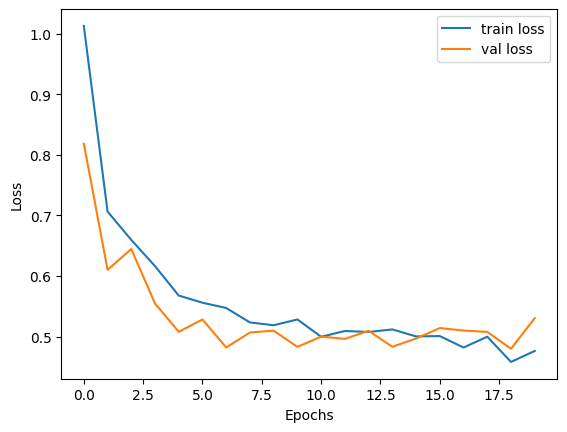

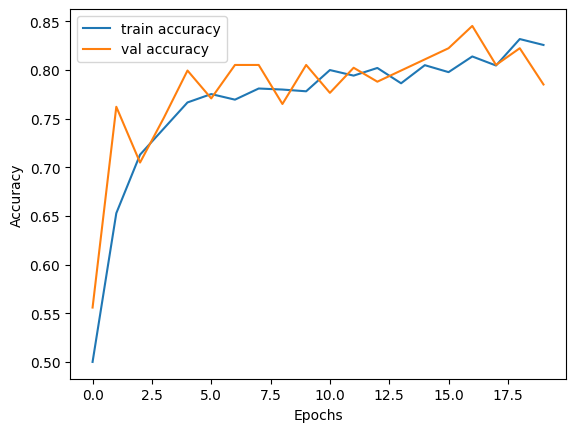

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

11/11 [==============================] - 0s 33ms/step


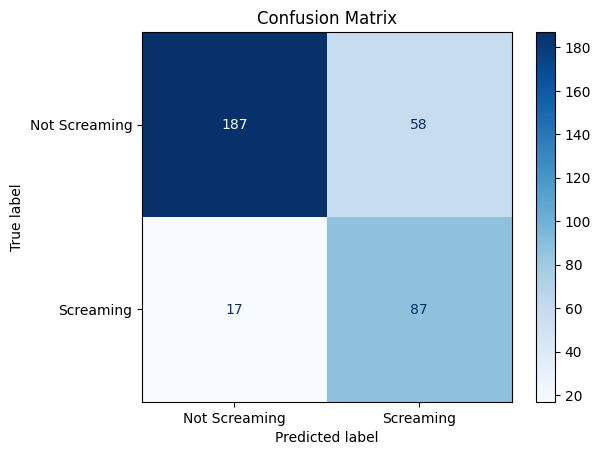

In [ ]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Regularization CNN in sugmented data

### Build and Train the model

In [ ]:
y_train_da_classes = np.argmax(y_train_da, axis=1)
train_da_class_counts = np.bincount(y_train_da_classes)

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_da_classes),
                                                  y=y_train_da_classes)
class_weights = dict(enumerate(class_weights))

adjusted_train_da_class_counts = train_da_class_counts * np.array([class_weights[0], class_weights[1]])

def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))

    # Compile the model with adjusted parameters
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_cnn_model(X_train, y_train, X_val, y_val, class_weights, epochs=20, batch_size=32):
    input_shape = (X_train.shape[1], X_train.shape[2], 1)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

    model = create_cnn_model(input_shape)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), class_weight=class_weights)

    return model, history
model, history = train_cnn_model(X_train_da, y_train_da, X_val, y_val, class_weights, epochs=20, batch_size=32)

Epoch 1/20
132/132 [==============================] - 45s 250ms/step - loss: 0.6438 - accuracy: 0.6280 - val_loss: 0.4628 - val_accuracy: 0.8052
Epoch 2/20
132/132 [==============================] - 28s 216ms/step - loss: 0.5159 - accuracy: 0.7708 - val_loss: 0.4617 - val_accuracy: 0.7822
Epoch 3/20
132/132 [==============================] - 28s 211ms/step - loss: 0.4781 - accuracy: 0.7879 - val_loss: 0.4574 - val_accuracy: 0.7822
Epoch 4/20
132/132 [==============================] - 28s 212ms/step - loss: 0.4581 - accuracy: 0.7979 - val_loss: 0.4424 - val_accuracy: 0.8052
Epoch 5/20
132/132 [==============================] - 28s 210ms/step - loss: 0.4159 - accuracy: 0.8192 - val_loss: 0.4826 - val_accuracy: 0.8166
Epoch 6/20
132/132 [==============================] - 28s 212ms/step - loss: 0.3780 - accuracy: 0.8361 - val_loss: 0.4869 - val_accuracy: 0.8367
Epoch 7/20
132/132 [==============================] - 28s 211ms/step - loss: 0.3274 - accuracy: 0.8608 - val_loss: 0.4683 - val_ac

### Evalution

In [ ]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))

11/11 [==============================] - 1s 135ms/step - loss: 1.0199 - accuracy: 0.7714
Test accuracy: 0.7714285850524902
11/11 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       252
           1       0.59      0.59      0.59        98

    accuracy                           0.77       350
   macro avg       0.72      0.72      0.72       350
weighted avg       0.77      0.77      0.77       350



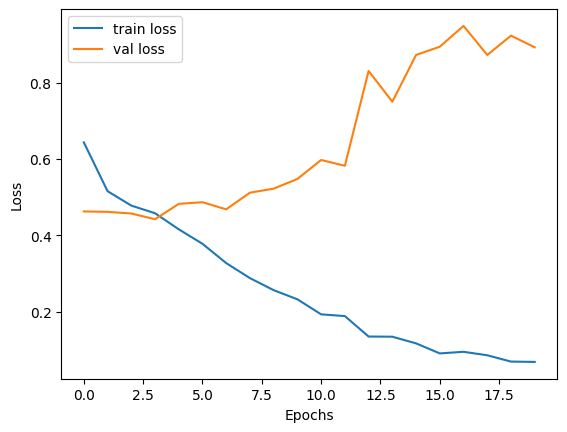

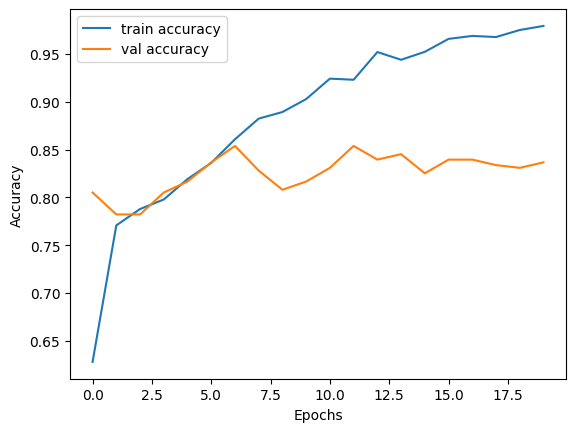

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

11/11 [==============================] - 0s 33ms/step


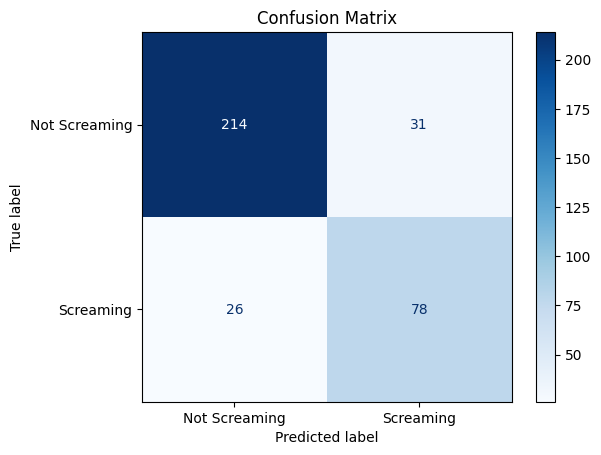

In [ ]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()